In [1]:
import jax 
import jax.numpy as jnp

import haiku as hk

import torch

import matplotlib.pyplot as plt

from scoresbibm.tasks import get_task
from scoresbibm.methods.score_transformer import run_train_transformer_model
from scoresbibm.methods.neural_nets import scalar_transformer_model
from scoresbibm.methods.sde import init_sde_related
from scoresbibm.utils.plot import use_style

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
thetas = torch.load("/mnt/qb/macke/mgloeckler90/thetas_0.pt")
theta1 = torch.load("/mnt/qb/macke/mgloeckler90/thetas_1.pt")
theta2 = torch.load("/mnt/qb/macke/mgloeckler90/thetas_2.pt")
theta3 = torch.load("/mnt/qb/macke/mgloeckler90/thetas_3.pt")
theta4 = torch.load("/mnt/qb/macke/mgloeckler90/thetas_4.pt")
theta5 = torch.load("/mnt/qb/macke/mgloeckler90/thetas_5.pt")
theta6 = torch.load("/mnt/qb/macke/mgloeckler90/thetas_6.pt")
theta7 = torch.load("/mnt/qb/macke/mgloeckler90/thetas_7.pt")
theta8 = torch.load("/mnt/qb/macke/mgloeckler90/thetas_8.pt")
theta9 = torch.load("/mnt/qb/macke/mgloeckler90/thetas_9.pt")


In [3]:
xs_raw = torch.load("/mnt/qb/macke/mgloeckler90/xs_0.pt")
xs_raw1 = torch.load("/mnt/qb/macke/mgloeckler90/xs_1.pt")
xs_raw2 = torch.load("/mnt/qb/macke/mgloeckler90/xs_2.pt")
xs_raw3 = torch.load("/mnt/qb/macke/mgloeckler90/xs_3.pt")
xs_raw4 = torch.load("/mnt/qb/macke/mgloeckler90/xs_4.pt")
xs_raw5 = torch.load("/mnt/qb/macke/mgloeckler90/xs_5.pt")
xs_raw6 = torch.load("/mnt/qb/macke/mgloeckler90/xs_6.pt")
xs_raw7 = torch.load("/mnt/qb/macke/mgloeckler90/xs_7.pt")
xs_raw8 = torch.load("/mnt/qb/macke/mgloeckler90/xs_8.pt")
xs_raw9 = torch.load("/mnt/qb/macke/mgloeckler90/xs_9.pt")

In [4]:
xs_raw[0].shape

torch.Size([2, 8192])

: 

In [4]:
thetas = torch.cat([thetas, theta1, theta2, theta3, theta4, theta5, theta6, theta7, theta8, theta9], dim=0)
xs_raw = torch.cat([xs_raw, xs_raw1, xs_raw2, xs_raw3, xs_raw4, xs_raw5, xs_raw6, xs_raw7, xs_raw8, xs_raw9], dim=0)

In [5]:
thetas = jnp.array(thetas.numpy())
xs_raw = jnp.array(xs_raw.numpy())

thetas = jax.device_put(thetas, jax.devices("cpu")[0])
xs_raw = jax.device_put(xs_raw, jax.devices("cpu")[0])

In [6]:
thetas_mean = jnp.mean(thetas, axis=0, keepdims=True)
thetas_std = jnp.std(thetas, axis=0, keepdims=True)

thetas = (thetas - thetas_mean) / thetas_std

In [7]:
def z_score_thetas(thetas):
    thetas = (thetas - thetas_mean) / thetas_std
    return thetas

def un_z_score_thetas(thetas):
    thetas = thetas * thetas_std + thetas_mean
    return thetas

In [8]:
xs_mean = jnp.mean(xs_raw, axis=0, keepdims=True)
xs_mean = jnp.mean(xs_mean, axis=-1, keepdims=True)
xs_std = jnp.std(xs_raw, axis=0, keepdims=True)
xs_std = jnp.std(xs_std, axis=-1, keepdims=True)

xs = (xs_raw - xs_mean) / xs_std

In [9]:
def z_score_xs(xs):
    xs = (xs - xs_mean) / xs_std
    return xs

def un_z_score_xs(xs):
    xs = xs * xs_std + xs_mean
    return xs

In [10]:
import numpy as np
def ravel(data, axis=-1):
    flat_data, tree = jax.tree_flatten(data)
    split_dims = np.cumsum(np.array([flat.shape[axis] for flat in flat_data]))[:-1]
    flat_data = jnp.concatenate(flat_data, axis=axis)
    def unravel(flat_data):
        flat_data = jnp.split(flat_data, split_dims, axis=axis)
        flat_data = jax.tree_unflatten(tree, flat_data)
        return flat_data
    def unflatten(flat_data):
        flat_data = jnp.split(flat_data, split_dims, axis=axis)
        return flat_data 
    return flat_data, unravel, unflatten

In [11]:
data = {"theta0": thetas[:, 0][:, None], "theta1": thetas[:, 1][:, None], "x0": xs[:, 0], "x1": xs[:, 1]}
data_flat, unravel, unflatten = ravel(data)
theta_dim = 2
x_dim = data_flat.shape[-1] - theta_dim
node_id = jnp.arange(0, 4)
condition_mask = jnp.array([False]*theta_dim + [True]*x_dim)

/tmp/ipykernel_1328236/1909208526.py:3: DeprecationWarning: jax.tree_flatten is deprecated: use jax.tree_util.tree_flatten.
  flat_data, tree = jax.tree_flatten(data)


In [12]:

sde, T_min, T_max, weight_fn, output_scale_fn =  init_sde_related(data_flat, "vesde", sigma_min=1e-5, sigma_max=15.)

In [13]:
from probjax.nn.helpers import GaussianFourierEmbedding
from probjax.nn.transformers import Transformer


token_dim = 100
id_dim = 40
cond_dim = 10

embedding_net1 = lambda x: jnp.repeat(x, token_dim, axis=-1)

embedding_net2 = lambda x:hk.Sequential([
        hk.Conv1D(output_channels=16, kernel_shape=9, stride=2, padding='SAME', name='conv1'), # 4000
        jax.nn.gelu,
        hk.Conv1D(output_channels=32, kernel_shape=6, stride=2, padding='SAME', name='conv2'), # 2000
        jax.nn.gelu,
        hk.Conv1D(output_channels=64, kernel_shape=3, stride=2, padding='SAME', name='conv3'), # 1000
        jax.nn.gelu,
        hk.Conv1D(output_channels=128, kernel_shape=3, stride=2, padding='SAME', name='conv4'), # 500
        jax.nn.gelu,
        hk.Conv1D(output_channels=256, kernel_shape=3, stride=2, padding='SAME', name='conv4'), # 250
        jax.nn.gelu,
        hk.Conv1D(output_channels=512, kernel_shape=3, stride=2, padding='SAME', name='conv4'), # 125
        jax.nn.gelu,
        hk.Conv1D(output_channels=512, kernel_shape=3, stride=2, padding='SAME', name='conv4'), # 64
        jax.nn.gelu,
        hk.Conv1D(output_channels=512, kernel_shape=3, stride=2, padding='SAME', name='conv4'), # 32
        jax.nn.gelu,
        hk.Conv1D(output_channels=512, kernel_shape=3, stride=2, padding='SAME', name='conv4'), # 16
        jax.nn.gelu,
        hk.Conv1D(output_channels=512, kernel_shape=3, stride=2, padding='SAME', name='conv4'), # 8
        jax.nn.gelu,
        hk.Conv1D(output_channels=512, kernel_shape=3, stride=2, padding='SAME', name='conv4'), # 4
        jax.nn.gelu,
        hk.Flatten(),
        hk.Linear(token_dim, name='linear'),
    ])(x)[..., None,:]

embedding_nets = [embedding_net1,embedding_net1, embedding_net2, embedding_net2]
output_fn = [lambda x: hk.Linear(1)(x), lambda x: hk.Linear(1)(x), lambda x: hk.Linear(8192)(x), lambda x: hk.Linear(8192)(x)]


def model(t, data, data_id, condition_mask, edge_mask=None):
    
    data = unflatten(data)

    assert len(data) == len(embedding_nets), "Number of data elements and embedding nets must match"
    
    data_embedded = jax.tree_map(lambda x, net: net(x[..., :,None]), data, embedding_nets)

    data_embedded = jnp.concatenate(data_embedded, axis=-2)
    
    _, current_nodes, _ = data_embedded.shape
    
    time_embeder = GaussianFourierEmbedding(128)
    id_embedder= hk.Embed(4, id_dim)
    
    id_embedding = id_embedder(data_id)
    id_embedding = jnp.broadcast_to(
        id_embedding, data_embedded.shape[:-1] + (id_dim,)
    )
    tokens = jnp.concatenate([data_embedded, id_embedding], axis=-1)
    time = time_embeder(t[..., None])
    
    condition_token = hk.get_parameter(
        "condition_token",
        shape=[1, 1, cond_dim],
        init=hk.initializers.RandomNormal(
            0.01, 0.
        ),
    )
    condition_mask = unflatten(condition_mask)
    condition_mask = jax.tree_map(lambda x: jnp.any(x, axis=-1, keepdims=True), condition_mask)
    condition_mask = jnp.concatenate(condition_mask, axis=-1)
    condition_mask = condition_mask.reshape(-1, current_nodes, 1)
    condition_token = condition_mask * condition_token
  
    condition_token = jnp.broadcast_to(
        condition_token, tokens.shape[:-1] + (cond_dim,)
    )
    tokens = jnp.concatenate([tokens, condition_token], -1)

    
    model = Transformer(
        num_heads=4,
        num_layers=8,
        attn_size=20,
        widening_factor=3,
    )
    
    h = model(tokens, context=time, mask=edge_mask)
    out = jnp.split(h, current_nodes, axis=-2)
    out = jax.tree_map(lambda x, fn: fn(x), out, output_fn)
    out = jnp.concatenate(out, axis=-1)
    out = jnp.squeeze(out, axis=-2)
    out = output_scale_fn(t, out)

    return out
    
    
init_fn, model_fn = hk.without_apply_rng(hk.transform(model))


In [14]:
params = init_fn(jax.random.PRNGKey(42), jnp.ones((1,)), data_flat[:10], node_id, condition_mask)

In [15]:
out = model_fn(params, jnp.ones((1,))*0.01, data_flat[:10], node_id, condition_mask)

In [211]:
import optax
optimizer = optax.adam(1e-4)
opt_state = optimizer.init(params)

In [212]:
from probjax.nn.loss_fn import denoising_score_matching_loss
from functools import partial




@jax.jit
def loss_fn(params, key, data, node_id):
    key_times, key_loss, key_condition = jax.random.split(key,3)
    times = jax.random.uniform(key_times, (data.shape[0],), minval=T_min, maxval =T_max)
    condition_mask1 = jnp.array([False]*theta_dim + [True]*x_dim)
    condition_mask2 = jnp.array([False]*theta_dim + [True]*(x_dim//2) + [False]*(x_dim//2))
    condition_mask3 = jnp.array([False]*theta_dim + [False]*(x_dim//2) + [True]*(x_dim//2))

    edge_mask1 = jnp.ones((4,4), dtype=bool)
    # Partial posterior
    edge_mask2 = edge_mask1.at[:, 2].set(False)
    edge_mask2 = edge_mask2.at[2, :].set(False)
    # Partial posterior 2
    edge_mask3 = edge_mask1.at[:, 3].set(False)
    edge_mask3 = edge_mask3.at[3, :].set(False)
    
    edge_masks = jax.random.choice(key_condition, jnp.stack([edge_mask1, edge_mask2, edge_mask3]), (data.shape[0],))
    condition_mask = jax.random.choice(key_condition, jnp.stack([condition_mask1, condition_mask2, condition_mask3]), (data.shape[0],))
    l_mask = jnp.broadcast_to(condition_mask1, (data.shape[0],) + condition_mask1.shape)
    
    loss = denoising_score_matching_loss(params, key_loss, times, data, l_mask, node_id, model_fn = model_fn, mean_fn = sde.marginal_mean, std_fn=sde.marginal_stddev, weight_fn=weight_fn, edge_mask=edge_masks, condition_mask=condition_mask, axis=-1)
    return loss



@partial(jax.pmap, axis_name="num_devices")
def update(params, opt_state, key, data, node_id):
    loss, grads = jax.value_and_grad(loss_fn)(params, key, data, node_id)

    loss = jax.lax.pmean(loss, axis_name="num_devices")
    grads = jax.lax.pmean(grads, axis_name="num_devices")
    
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state
    

In [213]:
n_devices = jax.local_device_count()
replicated_params = jax.tree_map(lambda x: jnp.array([x] * n_devices), params)
replicated_opt_state = jax.tree_map(lambda x: jnp.array([x] * n_devices), opt_state)

In [214]:
key = jax.random.PRNGKey(0)

In [215]:

node_id_repeated = node_id[None, ...]
node_id_repeated = jnp.repeat(node_id_repeated, n_devices, axis=0)
for _ in range(40):
    l = 0
    for _ in range(2000):
        key, subkey = jax.random.split(key)
        data_batch = jax.random.choice(subkey, data_flat, (n_devices, 32))
        loss, replicated_params, replicated_opt_state = update(replicated_params, replicated_opt_state, jax.random.split(subkey, (n_devices,)), data_batch, node_id_repeated)
        l += loss[0] / 2000
    print(l)



54.21604
50.97255
48.051147
46.361435
45.062645
44.422546
43.709637
43.247375
43.455368
42.942883
42.825542
42.43278
42.431362
42.26593
42.74616
42.355034
42.480682
42.50439
41.785824
42.31376
42.16089
42.236732
42.399654
42.214718
42.14661
42.44812
41.784958
42.098953
42.420586
41.930786
41.83285
42.055134
41.60987
41.869953
41.931175
42.076084
41.571774
41.899845
41.60922
41.78505


In [216]:
params = jax.tree_map(lambda x: x[0], replicated_params)

In [329]:
#jnp.save("only_post_params.pt", params)

In [16]:
params = jnp.load("only_post_params.pt.npy", allow_pickle=True).item()
# unpack the parameters


In [17]:
end_mean = sde.marginal_mean(jnp.array(1.0))[None, ...]
end_mean = jax.device_put(end_mean, jax.devices()[0])

In [18]:
end_std = sde.marginal_stddev(jnp.array(1.0))[None, ...]
end_std = jax.device_put(end_std, jax.devices()[0])

In [19]:
from functools import partial
from probjax.utils.sdeint import sdeint


# Reverse SDE drift
def drift_backward(t, x, node_ids=None, condition_mask=None, edge_mask=None, score_fn = model_fn):
    score = score_fn(params, t.reshape(-1, 1), x[None,...], node_ids,condition_mask, edge_mask=edge_mask)
    score = score.reshape(x.shape)

    f =  sde.drift(t,x) - sde.diffusion(t,x)**2 * score
    f = f * (1-condition_mask)
    
    return f.reshape(x.shape)

# Reverse SDE diffusion
def diffusion_backward(t,x, **kwargs):
    #t = T - t
    b =  sde.diffusion(t,x) 
    b = b * (1-condition_mask)
    return b.reshape(x.shape)

In [20]:



def sample_fn(key, shape, node_ids,condition_mask, condition_value, time_steps=1000, edge_mask=None, score_fn=model_fn):

    key1, key2 = jax.random.split(key, 2)
    # Sample from noise distribution at time 1
    x_T = jax.random.normal(key1, shape + (condition_value.shape[0],)) * end_std + end_mean

    
    x_T = x_T * (1-condition_mask) + condition_value * condition_mask
    # Solve backward sde
    keys = jax.random.split(key2, shape)
    ys = jax.vmap(lambda *args: sdeint(*args, noise_type="diagonal", only_final=True), in_axes= (0, None, None, 0, None), out_axes=0)(keys, lambda t, x: drift_backward(t, x, node_ids, condition_mask, edge_mask=edge_mask, score_fn=score_fn), lambda t, x: diffusion_backward(t, x), x_T, jnp.linspace(1.,T_min, time_steps))
    return ys

In [21]:
thetas_test = torch.load("/mnt/qb/macke/mgloeckler90/thetas_10.pt")
thetas_test = jnp.array(thetas_test.numpy())
thetas_test = z_score_thetas(thetas_test)
thetas_test = jax.device_put(thetas_test, jax.devices()[0])

In [22]:
xs_test = torch.load("/mnt/qb/macke/mgloeckler90/xs_10.pt")
xs_test = jnp.array(xs_test.numpy())
xs_test = z_score_xs(xs_test).reshape(xs_test.shape[0],-1)
xs_test = jax.device_put(xs_test, jax.devices()[0])

In [23]:
data_test_flat = jnp.concatenate([thetas_test, xs_test], axis=-1)

In [24]:
thetas_mean = jax.device_put(thetas_mean, jax.devices()[0])
thetas_std = jax.device_put(thetas_std, jax.devices()[0])

In [25]:
edge_mask = jnp.ones((4,4), dtype=bool)
edge_mask1 = edge_mask.at[:, 2].set(False)
edge_mask1 = edge_mask1.at[2, :].set(False)

edge_mask2 = edge_mask.at[:, 3].set(False)
edge_mask2 = edge_mask2.at[3, :].set(False)

In [26]:
((thetas_test[:, 0] - thetas_test[:, 1])**2).argsort()

Array([9848, 6400, 9914, ..., 1774, 9448,  733], dtype=int32)

In [350]:
index = 5000
x_o = jax.device_put(data_test_flat[index], jax.devices()[0])
x_o[:2]

Array([1.645, 0.385], dtype=float32)

In [351]:
sample = sample_fn(jax.random.PRNGKey(0), (2000,), node_id, condition_mask, x_o)

In [352]:
x_o_dict = unravel(x_o)

/tmp/ipykernel_3308156/1909208526.py:8: DeprecationWarning: jax.tree_unflatten is deprecated: use jax.tree_util.tree_unflatten.
  flat_data = jax.tree_unflatten(tree, flat_data)


In [353]:


sample_partial1 = sample_fn(jax.random.PRNGKey(1), (2000,), node_id, condition_mask, x_o, edge_mask=edge_mask1)
sample_partial2 = sample_fn(jax.random.PRNGKey(2), (2000,), node_id, condition_mask, x_o, edge_mask=edge_mask2)

In [354]:
thetas = un_z_score_thetas(sample[:, :2])
thetas_partial1 = un_z_score_thetas(sample_partial1[:, :2])
thetas_partial2 = un_z_score_thetas(sample_partial2[:, :2])
theta_true = un_z_score_thetas(x_o[:2])

In [355]:
import matplotlib.pyplot as plt

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

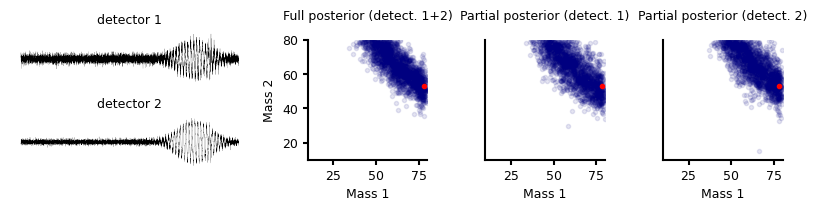

In [356]:
import matplotlib.gridspec as gridspec

with use_style("pyloric"):
    fig = plt.figure(figsize=(8, 2.))
    gs = gridspec.GridSpec(2, 4, height_ratios=[1, 1], width_ratios=[2, 1, 1, 1]) 

    ax0_upper = plt.subplot(gs[0,0])
    ax0_upper.plot(x_o_dict["x0"], lw=0.1, color="black")
    ax0_upper.set_title("detector 1")
    ax0_upper.axis("off")

    ax0_lower = plt.subplot(gs[1,0])
    ax0_lower.plot(x_o_dict["x1"],lw=0.1, color="black")
    ax0_lower.set_title("detector 2")
    ax0_lower.axis("off")
    
    ax1 = plt.subplot(gs[:, 1])
    ax1.scatter(thetas[:, 0], thetas[:, 1], alpha=0.1, color="navy")
    ax1.scatter(theta_true[:,0], theta_true[:,1], color="red")
    ax1.set_title("Full posterior (detect. 1+2)", y=1.1)
    ax1.set_ylabel("Mass 2")

    ax2 = plt.subplot(gs[:, 2])
    ax2.scatter(thetas_partial1[:, 0], thetas_partial1[:, 1], alpha=0.1, color="navy")
    ax2.scatter(theta_true[:,0], theta_true[:,1], color="red")
    ax2.set_yticks([])
    ax2.set_title("Partial posterior (detect. 1)", y=1.1)

    ax3 = plt.subplot(gs[:, 3])
    ax3.scatter(thetas_partial2[:, 0], thetas_partial2[:, 1], alpha=0.1, color="navy")
    ax3.scatter(theta_true[:,0], theta_true[:,1], color="red")
    ax3.set_yticks([])
    ax3.set_title("Partial posterior (detect. 2)", y=1.1)

    axes = [ax1, ax2, ax3]
    for ax in axes:
        ax.set_xlim(10,80)
        ax.set_ylim(10,80)
        ax.set_aspect("equal")
        ax.set_xlabel("Mass 1")
        
    fig.tight_layout()

    fig.savefig(f"posteriors_obsevation{index}.svg")
    
    plt.show()

In [243]:
# Reverse SDE drift
def drift_ode(t, x, x_o,node_ids=node_id, condition_mask=np.array(condition_mask), edge_mask=edge_mask, score_fn = model_fn):
    x = x_o.at[~condition_mask].set(x)
    score = score_fn(params, t.reshape(-1, 1), x[None,...], node_ids,condition_mask, edge_mask=edge_mask)
    score = score.reshape(x.shape)

    f =  sde.drift(t,x) - 0.5*sde.diffusion(t,x)**2 * score
    f = f * (1-condition_mask)
    
    return f[~condition_mask]


In [244]:
from probjax.utils.odeint import odeint
from probjax.distributions import Normal, Independent
from probjax.distributions.transformed_distribution import TransformedDistribution

In [245]:
x_o = jax.device_put(data_test_flat[index], jax.devices()[0])
m0 = jax.device_put(end_mean[0,~condition_mask], jax.devices()[0])
s0 = jax.device_put(end_std[0,~condition_mask], jax.devices()[0])
q0 = Independent(Normal(m0,s0),1)

In [246]:
@jax.jit
def sample_post(key, x_o):
    thetas =  sample_fn(key, (500,), node_id, condition_mask, x_o)[:, :2]
    return un_z_score_thetas(thetas)

In [247]:
@jax.jit
def log_probs_post(thetas, x_o):
    def f(x_T):
        y = odeint(lambda t,x: drift_ode(t,x,x_o), x_T, jnp.linspace(1e-5,1, 100)[::-1], method="rk3")[-1]
        y = un_z_score_thetas(y)
        return y

    q = TransformedDistribution(q0, f)
    return q.log_prob(thetas)

In [248]:
log_probs_q = []
log_probs_true = []

for i in range(50):
    x_o = jax.device_put(data_test_flat[i], jax.devices()[0])
    theta_true = un_z_score_thetas(x_o[:2])
    key = jax.random.PRNGKey(i)
    thetas = sample_post(key, x_o)
    log_prob = log_probs_post(thetas, x_o)
    log_prob_true = log_probs_post(theta_true, x_o)
    
    log_probs_q.append(log_prob)
    log_probs_true.append(log_prob_true)
    

In [252]:
for i in range(50,100):
    x_o = jax.device_put(data_test_flat[i], jax.devices()[0])
    theta_true = un_z_score_thetas(x_o[:2])
    key = jax.random.PRNGKey(i)
    thetas = sample_post(key, x_o)
    log_prob = log_probs_post(thetas, x_o)
    log_prob_true = log_probs_post(theta_true, x_o)
    
    log_probs_q.append(log_prob)
    log_probs_true.append(log_prob_true)
    

In [256]:
log_probs_q_vec = jnp.stack(log_probs_q)
log_probs_true_vec = jnp.stack(log_probs_true)

In [330]:
jnp.save("log_probs_q_vec_test.pt", log_probs_q_vec)
jnp.save("log_probs_true_test.pt", log_probs_true_vec)

In [336]:
alphas = jnp.linspace(0,1, 30)
covs = []
for alpha in alphas:
    a = 1- alpha
    cov_a = jnp.mean(log_probs_q_vec > jnp.percentile(log_probs_true_vec, a*100, axis=0))
    covs.append(cov_a)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

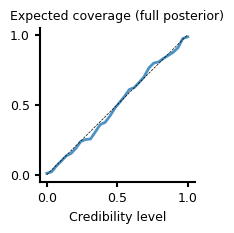

In [349]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(2,2))
    plt.plot(alphas, covs, color="C0", lw=2, alpha=0.8)
    plt.plot(alphas,alphas, "--", color="black", lw=0.5)
    plt.xticks([0,0.5,1])
    plt.yticks([0,0.5,1])
    plt.xlabel("Credibility level")
    plt.title("Expected coverage (full posterior)")
    fig.savefig("ec_gw_test.svg")
    plt.show()

In [47]:
log_probs_q_vec = jnp.load("log_probs_q_vec_full_posterior.npy")
log_probs_true_vec = jnp.load("log_probs_true_vec_full_posterior.npy")

In [48]:
alphas = jnp.linspace(0,1, 50)
covs = []
for alpha in alphas:
    a = 1- alpha
    cov_a = jnp.mean(log_probs_q_vec > jnp.percentile(log_probs_true_vec, a*100, axis=0))
    covs.append(cov_a)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

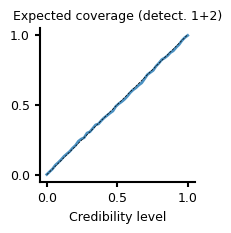

In [49]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(2,2))
    plt.plot(alphas, covs, color="C0", lw=2, alpha=0.8)
    plt.plot(alphas,alphas, "--", color="black", lw=0.5)
    plt.xticks([0,0.5,1])
    plt.yticks([0,0.5,1])
    plt.xlabel("Credibility level")
    plt.title("Expected coverage (detect. 1+2)")
    fig.savefig("ec_gw_full_post.svg")
    plt.show()

In [44]:
log_probs_q_vec = jnp.load("log_probs_q_vec_partial1_posterior.npy")
log_probs_true_vec = jnp.load("log_probs_true_vec_partial1_posterior.npy")

In [45]:
alphas = jnp.linspace(0,1, 50)
covs = []
for alpha in alphas:
    a = 1- alpha
    cov_a = jnp.mean(log_probs_q_vec > jnp.percentile(log_probs_true_vec, a*100, axis=0))
    covs.append(cov_a)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

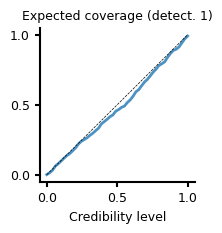

In [46]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(2,2))
    plt.plot(alphas, covs, color="C0", lw=2, alpha=0.8)
    plt.plot(alphas,alphas, "--", color="black", lw=0.5)
    plt.xticks([0,0.5,1])
    plt.yticks([0,0.5,1])
    plt.xlabel("Credibility level")
    plt.title("Expected coverage (detect. 1)")
    fig.savefig("ec_gw_partial1_post.svg")
    plt.show()

In [41]:
log_probs_q_vec = jnp.load("log_probs_q_vec_partial2_posterior.npy")
log_probs_true_vec = jnp.load("log_probs_true_vec_partial2_posterior.npy")

In [42]:
alphas = jnp.linspace(0,1, 50)
covs = []
for alpha in alphas:
    a = 1- alpha
    cov_a = jnp.mean(log_probs_q_vec > jnp.percentile(log_probs_true_vec, a*100, axis=0))
    covs.append(cov_a)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

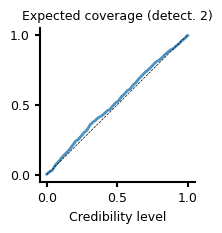

In [43]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(2,2))
    plt.plot(alphas, covs, color="C0", lw=2, alpha=0.8)
    plt.plot(alphas,alphas, "--", color="black", lw=0.5)
    plt.xticks([0,0.5,1])
    plt.yticks([0,0.5,1])
    plt.xlabel("Credibility level")
    plt.title("Expected coverage (detect. 2)")
    fig.savefig("ec_gw_partial2_post.svg")
    plt.show()